In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()
#gec.load_gp_datas("./gp_datas.json")


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]
ind = np.random.uniform(0, 1, X.shape[0]) > 0.3
X = X[ind,:]
y = y[ind]

X_pos = X[y==1,:]
y_pos = y[y==1]

X_reweighted = np.concatenate([X] + [X_pos]*3, axis=0)
y_reweighted = np.concatenate([y] + [y_pos]*3)

/tmp/ipykernel_11260/3574338328.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_11260/3574338328.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [14]:
gec.fit(X_reweighted, y_reweighted, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

{'boosting': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.28824274781692216, 'n_estimators': 700, 'bagging_fraction': 0.1, 'bagging_freq': 2, 'max_bin': 40, 'max_depth': 250, 'lambda_l1': 0.49580857974270476, 'min_data_in_leaf': 25, 'feature_fraction': 0.32999999999999985}


  1%|          | 1/100 [00:08<13:24,  8.13s/it]

{'boosting': 'dart', 'num_leaves': 14, 'learning_rate': 0.011517611256881522, 'n_estimators': 500, 'bagging_fraction': 0.7000000000000002, 'bagging_freq': 8, 'max_bin': 50, 'max_depth': 250, 'lambda_l1': 0.39276427868095354, 'min_data_in_leaf': 3, 'feature_fraction': 0.23999999999999994}


  2%|▏         | 2/100 [00:22<19:23, 11.88s/it]

{'boosting': 'rf', 'num_leaves': 86, 'learning_rate': 0.1772106966534, 'n_estimators': 20, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 5, 'max_bin': 40, 'max_depth': 400, 'lambda_l1': 0.5100900202791361, 'min_data_in_leaf': 7, 'feature_fraction': 0.7199999999999996}


  3%|▎         | 3/100 [00:23<10:50,  6.71s/it]

{'boosting': 'dart', 'num_leaves': 86, 'learning_rate': 0.010498344148546002, 'n_estimators': 30, 'bagging_fraction': 0.5500000000000002, 'bagging_freq': 9, 'max_bin': 400, 'max_depth': -1, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 37, 'feature_fraction': 0.5199999999999998}


  4%|▍         | 4/100 [00:24<07:02,  4.40s/it]

{'boosting': 'gbdt', 'num_leaves': 108, 'learning_rate': 0.20363496438760362, 'n_estimators': 900, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 5, 'max_bin': 140, 'max_depth': 70, 'lambda_l1': 0.7694254426154639, 'min_data_in_leaf': 32, 'feature_fraction': 0.9299999999999996}


  5%|▌         | 5/100 [00:32<09:31,  6.02s/it]

{'boosting': 'rf', 'num_leaves': 131, 'learning_rate': 0.012063774801355676, 'n_estimators': 90, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 1, 'max_bin': 1000, 'max_depth': 160, 'lambda_l1': 0.8780167616055987, 'min_data_in_leaf': 35, 'feature_fraction': 0.9699999999999995}


  6%|▌         | 6/100 [00:34<07:01,  4.48s/it]

{'boosting': 'dart', 'num_leaves': 143, 'learning_rate': 0.016685101735522026, 'n_estimators': 30, 'bagging_fraction': 0.9500000000000003, 'bagging_freq': 7, 'max_bin': 800, 'max_depth': 100, 'lambda_l1': 0.45490422386848667, 'min_data_in_leaf': 39, 'feature_fraction': 0.22999999999999995}


  7%|▋         | 7/100 [00:35<05:12,  3.36s/it]

{'boosting': 'gbdt', 'num_leaves': 92, 'learning_rate': 0.15421531907756736, 'n_estimators': 200, 'bagging_fraction': 0.5500000000000002, 'bagging_freq': 1, 'max_bin': 350, 'max_depth': 10, 'lambda_l1': 1.0, 'min_data_in_leaf': 45, 'feature_fraction': 0.9699999999999995}


  8%|▊         | 8/100 [00:39<05:14,  3.42s/it]

{'boosting': 'rf', 'num_leaves': 160, 'learning_rate': 0.23399941145903164, 'n_estimators': 600, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 6, 'max_bin': 10, 'max_depth': 160, 'lambda_l1': 0.005290639198851643, 'min_data_in_leaf': 42, 'feature_fraction': 0.15999999999999998}


  9%|▉         | 9/100 [00:43<05:26,  3.59s/it]

{'boosting': 'dart', 'num_leaves': 20, 'learning_rate': 0.027139217116550353, 'n_estimators': 20, 'bagging_fraction': 0.3500000000000001, 'bagging_freq': 5, 'max_bin': 100, 'max_depth': 40, 'lambda_l1': 0.01964577249277761, 'min_data_in_leaf': 10, 'feature_fraction': 0.7499999999999997}


 10%|█         | 10/100 [00:43<03:55,  2.61s/it]

{'boosting': 'gbdt', 'num_leaves': 199, 'learning_rate': 0.013545194166432404, 'n_estimators': 350, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 9, 'max_bin': 800, 'max_depth': 160, 'lambda_l1': 0.06580919926012137, 'min_data_in_leaf': 37, 'feature_fraction': 0.8099999999999996}


 11%|█         | 11/100 [00:52<06:56,  4.68s/it]

{'boosting': 'rf', 'num_leaves': 59, 'learning_rate': 0.22864113240862843, 'n_estimators': 20, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 7, 'max_bin': 10, 'max_depth': 100, 'lambda_l1': 0.11739025648318352, 'min_data_in_leaf': 43, 'feature_fraction': 0.13999999999999999}


 12%|█▏        | 12/100 [00:53<05:03,  3.45s/it]

{'boosting': 'dart', 'num_leaves': 74, 'learning_rate': 0.012931962290146218, 'n_estimators': 80, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 350, 'max_depth': 40, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 33, 'feature_fraction': 0.13}


 13%|█▎        | 13/100 [00:56<04:38,  3.20s/it]

{'boosting': 'rf', 'num_leaves': 30, 'learning_rate': 0.2627343029221093, 'n_estimators': 800, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 1, 'max_bin': 500, 'max_depth': 10, 'lambda_l1': 0.17722491237774848, 'min_data_in_leaf': 5, 'feature_fraction': 0.16999999999999998}


 14%|█▍        | 14/100 [01:06<07:46,  5.42s/it]

{'boosting': 'gbdt', 'num_leaves': 152, 'learning_rate': 0.2567180326144539, 'n_estimators': 600, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 200, 'max_depth': 70, 'lambda_l1': 0.3374463620662838, 'min_data_in_leaf': 26, 'feature_fraction': 0.9799999999999995}


 15%|█▌        | 15/100 [01:18<10:35,  7.48s/it]

{'boosting': 'dart', 'num_leaves': 10, 'learning_rate': 0.025910542737369875, 'n_estimators': 160, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 4, 'max_bin': 450, 'max_depth': -1, 'lambda_l1': 0.02272261558430914, 'min_data_in_leaf': 21, 'feature_fraction': 0.1}


 16%|█▌        | 16/100 [01:23<09:12,  6.58s/it]

{'boosting': 'rf', 'num_leaves': 16, 'learning_rate': 0.06698121484753657, 'n_estimators': 900, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 2, 'max_bin': 1000, 'max_depth': 250, 'lambda_l1': 0.27902130380168133, 'min_data_in_leaf': 46, 'feature_fraction': 0.5699999999999997}


 17%|█▋        | 17/100 [01:34<10:50,  7.84s/it]

{'boosting': 'gbdt', 'num_leaves': 197, 'learning_rate': 0.13113079614562567, 'n_estimators': 80, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 70, 'max_depth': 160, 'lambda_l1': 0.02587185993800735, 'min_data_in_leaf': 4, 'feature_fraction': 0.3899999999999999}


 18%|█▊        | 18/100 [01:37<08:56,  6.54s/it]

{'boosting': 'dart', 'num_leaves': 186, 'learning_rate': 0.011787530210038817, 'n_estimators': 30, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 180, 'max_depth': 10, 'lambda_l1': 0.16411959511019011, 'min_data_in_leaf': 8, 'feature_fraction': 0.12}


 19%|█▉        | 19/100 [01:38<06:37,  4.91s/it]

{'boosting': 'rf', 'num_leaves': 24, 'learning_rate': 0.012931962290146218, 'n_estimators': 350, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 2, 'max_bin': 30, 'max_depth': 100, 'lambda_l1': 0.49580857974270476, 'min_data_in_leaf': 11, 'feature_fraction': 1.0}


 20%|██        | 20/100 [01:43<06:25,  4.82s/it]

{'boosting': 'gbdt', 'num_leaves': 192, 'learning_rate': 0.21828985734380807, 'n_estimators': 1000, 'bagging_fraction': 0.9500000000000003, 'bagging_freq': 4, 'max_bin': 100, 'max_depth': 70, 'lambda_l1': 0.21278367364724188, 'min_data_in_leaf': 17, 'feature_fraction': 0.9599999999999995}


 21%|██        | 21/100 [02:01<11:28,  8.72s/it]

{'boosting': 'dart', 'num_leaves': 19, 'learning_rate': 0.04023686733151743, 'n_estimators': 10, 'bagging_fraction': 0.9500000000000003, 'bagging_freq': 9, 'max_bin': 160, 'max_depth': 70, 'lambda_l1': 0.3374463620662838, 'min_data_in_leaf': 6, 'feature_fraction': 0.5099999999999998}


 22%|██▏       | 22/100 [02:02<08:14,  6.34s/it]

{'boosting': 'rf', 'num_leaves': 193, 'learning_rate': 0.21828985734380807, 'n_estimators': 70, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 6, 'max_bin': 450, 'max_depth': 10, 'lambda_l1': 0.404620981512531, 'min_data_in_leaf': 27, 'feature_fraction': 0.34999999999999987}


 23%|██▎       | 23/100 [02:03<06:25,  5.00s/it]

{'boosting': 'gbdt', 'num_leaves': 138, 'learning_rate': 0.12812807321795364, 'n_estimators': 40, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'max_bin': 800, 'max_depth': 160, 'lambda_l1': 0.2700521429238798, 'min_data_in_leaf': 43, 'feature_fraction': 0.18999999999999995}


 24%|██▍       | 24/100 [02:05<05:11,  4.09s/it]

{'boosting': 'dart', 'num_leaves': 188, 'learning_rate': 0.02103453355565287, 'n_estimators': 500, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 7, 'max_bin': 200, 'max_depth': 400, 'lambda_l1': 0.013702670330891934, 'min_data_in_leaf': 38, 'feature_fraction': 0.12}


 25%|██▌       | 25/100 [02:49<19:51, 15.89s/it]

{'boosting': 'dart', 'num_leaves': 16, 'learning_rate': 0.010023052380778996, 'n_estimators': 1000, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 160, 'max_depth': 160, 'lambda_l1': 0.02909520922955782, 'min_data_in_leaf': 43, 'feature_fraction': 0.7399999999999997}


 26%|██▌       | 26/100 [04:18<46:42, 37.87s/it]

{'boosting': 'gbdt', 'num_leaves': 180, 'learning_rate': 0.04414339914578985, 'n_estimators': 450, 'bagging_fraction': 0.40000000000000013, 'bagging_freq': 9, 'max_bin': 180, 'max_depth': 10, 'lambda_l1': 0.9494982851798157, 'min_data_in_leaf': 15, 'feature_fraction': 0.5899999999999997}


 27%|██▋       | 27/100 [04:31<36:52, 30.31s/it]

{'boosting': 'rf', 'num_leaves': 89, 'learning_rate': 0.0297741194365231, 'n_estimators': 30, 'bagging_fraction': 0.1, 'bagging_freq': 3, 'max_bin': 250, 'max_depth': 160, 'lambda_l1': 0.9251148298702443, 'min_data_in_leaf': 36, 'feature_fraction': 0.8699999999999996}


 28%|██▊       | 28/100 [04:31<25:46, 21.47s/it]

{'boosting': 'rf', 'num_leaves': 131, 'learning_rate': 0.2508395269915473, 'n_estimators': 250, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 9, 'max_bin': 60, 'max_depth': 400, 'lambda_l1': 0.050092086499548855, 'min_data_in_leaf': 47, 'feature_fraction': 0.2799999999999999}


 29%|██▉       | 29/100 [04:37<19:44, 16.68s/it]

{'boosting': 'dart', 'num_leaves': 97, 'learning_rate': 0.011787530210038817, 'n_estimators': 30, 'bagging_fraction': 0.45000000000000007, 'bagging_freq': 7, 'max_bin': 500, 'max_depth': 40, 'lambda_l1': 0.01964577249277761, 'min_data_in_leaf': 30, 'feature_fraction': 0.12}


 30%|███       | 30/100 [04:38<14:03, 12.06s/it]

{'boosting': 'gbdt', 'num_leaves': 194, 'learning_rate': 0.09703300095601607, 'n_estimators': 700, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 9, 'max_bin': 250, 'max_depth': 10, 'lambda_l1': 0.2975977524254038, 'min_data_in_leaf': 41, 'feature_fraction': 0.8999999999999996}


 31%|███       | 31/100 [04:53<14:39, 12.74s/it]

{'boosting': 'dart', 'num_leaves': 73, 'learning_rate': 0.013862630182301694, 'n_estimators': 40, 'bagging_fraction': 0.9500000000000003, 'bagging_freq': 9, 'max_bin': 900, 'max_depth': -1, 'lambda_l1': 0.11213700028500526, 'min_data_in_leaf': 25, 'feature_fraction': 0.2899999999999999}


 32%|███▏      | 32/100 [04:55<10:49,  9.54s/it]

{'boosting': 'gbdt', 'num_leaves': 13, 'learning_rate': 0.15421531907756736, 'n_estimators': 900, 'bagging_fraction': 0.40000000000000013, 'bagging_freq': 1, 'max_bin': 900, 'max_depth': 100, 'lambda_l1': 0.6912010020428295, 'min_data_in_leaf': 44, 'feature_fraction': 0.9199999999999996}


 33%|███▎      | 33/100 [05:09<12:10, 10.90s/it]

{'boosting': 'rf', 'num_leaves': 129, 'learning_rate': 0.0462366730725511, 'n_estimators': 30, 'bagging_fraction': 0.40000000000000013, 'bagging_freq': 2, 'max_bin': 800, 'max_depth': 160, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 38, 'feature_fraction': 1.0}


 34%|███▍      | 34/100 [05:11<09:08,  8.31s/it]

{'boosting': 'dart', 'num_leaves': 41, 'learning_rate': 0.014860274972939862, 'n_estimators': 140, 'bagging_fraction': 0.6500000000000001, 'bagging_freq': 6, 'max_bin': 600, 'max_depth': 10, 'lambda_l1': 0.5866990490926948, 'min_data_in_leaf': 49, 'feature_fraction': 0.32999999999999985}


 35%|███▌      | 35/100 [05:18<08:36,  7.95s/it]

{'boosting': 'rf', 'num_leaves': 116, 'learning_rate': 0.28824274781692216, 'n_estimators': 700, 'bagging_fraction': 0.1, 'bagging_freq': 2, 'max_bin': 140, 'max_depth': 250, 'lambda_l1': 0.6031192352538136, 'min_data_in_leaf': 8, 'feature_fraction': 0.9399999999999996}


 36%|███▌      | 36/100 [05:33<10:34,  9.91s/it]

{'boosting': 'gbdt', 'num_leaves': 95, 'learning_rate': 0.08844592989660137, 'n_estimators': 1000, 'bagging_fraction': 0.1, 'bagging_freq': 3, 'max_bin': 10, 'max_depth': 100, 'lambda_l1': 0.02587185993800735, 'min_data_in_leaf': 10, 'feature_fraction': 0.9199999999999996}


 37%|███▋      | 37/100 [05:53<13:45, 13.11s/it]

{'boosting': 'dart', 'num_leaves': 189, 'learning_rate': 0.011253873093081734, 'n_estimators': 250, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 700, 'max_depth': 400, 'lambda_l1': 0.2527276847641921, 'min_data_in_leaf': 41, 'feature_fraction': 0.3699999999999999}


 38%|███▊      | 38/100 [06:08<14:09, 13.69s/it]

{'boosting': 'rf', 'num_leaves': 151, 'learning_rate': 0.27519312749418795, 'n_estimators': 500, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 3, 'max_bin': 250, 'max_depth': 250, 'lambda_l1': 0.005290639198851643, 'min_data_in_leaf': 44, 'feature_fraction': 0.15999999999999998}


 39%|███▉      | 39/100 [06:19<13:07, 12.92s/it]

{'boosting': 'gbdt', 'num_leaves': 195, 'learning_rate': 0.0152085303337838, 'n_estimators': 160, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 2, 'max_bin': 400, 'max_depth': 40, 'lambda_l1': 0.8330593732318271, 'min_data_in_leaf': 46, 'feature_fraction': 0.24999999999999992}


 40%|████      | 40/100 [06:24<10:21, 10.36s/it]

{'boosting': 'rf', 'num_leaves': 182, 'learning_rate': 0.2508395269915473, 'n_estimators': 10, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 3, 'max_bin': 400, 'max_depth': 160, 'lambda_l1': 0.3374463620662838, 'min_data_in_leaf': 48, 'feature_fraction': 0.9699999999999995}


 41%|████      | 41/100 [06:24<07:20,  7.47s/it]

{'boosting': 'dart', 'num_leaves': 40, 'learning_rate': 0.07696892770978697, 'n_estimators': 20, 'bagging_fraction': 0.8500000000000002, 'bagging_freq': 8, 'max_bin': 160, 'max_depth': 250, 'lambda_l1': 0.5866990490926948, 'min_data_in_leaf': 19, 'feature_fraction': 0.18999999999999995}


 42%|████▏     | 42/100 [06:25<05:19,  5.50s/it]

{'boosting': 'gbdt', 'num_leaves': 197, 'learning_rate': 0.26889156647455614, 'n_estimators': 90, 'bagging_fraction': 0.5000000000000001, 'bagging_freq': 5, 'max_bin': 350, 'max_depth': 250, 'lambda_l1': 0.21278367364724188, 'min_data_in_leaf': 3, 'feature_fraction': 0.9799999999999995}


 43%|████▎     | 43/100 [06:32<05:26,  5.72s/it]

{'boosting': 'rf', 'num_leaves': 191, 'learning_rate': 0.04023686733151743, 'n_estimators': 600, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 3, 'max_bin': 160, 'max_depth': 10, 'lambda_l1': 0.4682231431110762, 'min_data_in_leaf': 48, 'feature_fraction': 0.9699999999999995}


 44%|████▍     | 44/100 [06:43<06:53,  7.39s/it]

{'boosting': 'dart', 'num_leaves': 22, 'learning_rate': 0.05313112273885736, 'n_estimators': 10, 'bagging_fraction': 0.9500000000000003, 'bagging_freq': 2, 'max_bin': 200, 'max_depth': 10, 'lambda_l1': 0.12827052111465376, 'min_data_in_leaf': 5, 'feature_fraction': 0.11}


 45%|████▌     | 45/100 [06:44<04:55,  5.36s/it]

{'boosting': 'gbdt', 'num_leaves': 166, 'learning_rate': 0.07180161755499491, 'n_estimators': 80, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 4, 'max_bin': 20, 'max_depth': 160, 'lambda_l1': 0.36986236456478433, 'min_data_in_leaf': 46, 'feature_fraction': 0.4099999999999998}


 46%|████▌     | 46/100 [06:47<04:21,  4.84s/it]

{'boosting': 'rf', 'num_leaves': 22, 'learning_rate': 0.013862630182301694, 'n_estimators': 50, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 3, 'max_bin': 1000, 'max_depth': -1, 'lambda_l1': 0.08305871111196488, 'min_data_in_leaf': 47, 'feature_fraction': 0.18999999999999995}


 47%|████▋     | 47/100 [06:48<03:18,  3.75s/it]

{'boosting': 'dart', 'num_leaves': 38, 'learning_rate': 0.047320244493297095, 'n_estimators': 40, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 9, 'max_bin': 800, 'max_depth': 10, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 21, 'feature_fraction': 0.6599999999999997}


 48%|████▊     | 48/100 [06:50<02:46,  3.20s/it]

{'boosting': 'gbdt', 'num_leaves': 170, 'learning_rate': 0.1813636867710672, 'n_estimators': 700, 'bagging_fraction': 0.5500000000000002, 'bagging_freq': 9, 'max_bin': 40, 'max_depth': 250, 'lambda_l1': 0.008029691334480369, 'min_data_in_leaf': 6, 'feature_fraction': 0.8499999999999996}


 49%|████▉     | 49/100 [07:13<07:41,  9.05s/it]

{'boosting': 'rf', 'num_leaves': 51, 'learning_rate': 0.16531365378686086, 'n_estimators': 200, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 1, 'max_bin': 180, 'max_depth': 100, 'lambda_l1': 0.02272261558430914, 'min_data_in_leaf': 29, 'feature_fraction': 0.11}


 50%|█████     | 50/100 [07:16<06:01,  7.24s/it]

{'boosting': 'dart', 'num_leaves': 24, 'learning_rate': 0.016303034829772797, 'n_estimators': 10, 'bagging_fraction': 1.0, 'bagging_freq': 9, 'max_bin': 20, 'max_depth': 40, 'lambda_l1': 0.10199002907472098, 'min_data_in_leaf': 20, 'feature_fraction': 0.7299999999999996}


 51%|█████     | 51/100 [07:17<04:17,  5.26s/it]

{'boosting': 'rf', 'num_leaves': 170, 'learning_rate': 0.16152818833500937, 'n_estimators': 1000, 'bagging_fraction': 0.1, 'bagging_freq': 9, 'max_bin': 10, 'max_depth': 400, 'lambda_l1': 0.6912010020428295, 'min_data_in_leaf': 41, 'feature_fraction': 0.17999999999999997}


 52%|█████▏    | 52/100 [07:25<04:59,  6.24s/it]

{'boosting': 'gbdt', 'num_leaves': 174, 'learning_rate': 0.049564163990267536, 'n_estimators': 120, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 2, 'max_bin': 500, 'max_depth': 40, 'lambda_l1': 0.01964577249277761, 'min_data_in_leaf': 3, 'feature_fraction': 0.8399999999999996}


 53%|█████▎    | 53/100 [07:34<05:29,  7.02s/it]

{'boosting': 'dart', 'num_leaves': 109, 'learning_rate': 0.022548315035021207, 'n_estimators': 10, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 9, 'max_bin': 400, 'max_depth': 40, 'lambda_l1': 0.0970908247622649, 'min_data_in_leaf': 46, 'feature_fraction': 0.18999999999999995}


 54%|█████▍    | 54/100 [07:35<03:56,  5.13s/it]

{'boosting': 'rf', 'num_leaves': 95, 'learning_rate': 0.26889156647455614, 'n_estimators': 160, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 3, 'max_bin': 180, 'max_depth': 400, 'lambda_l1': 0.327134006604184, 'min_data_in_leaf': 46, 'feature_fraction': 0.13999999999999999}


 55%|█████▌    | 55/100 [07:37<03:19,  4.43s/it]

{'boosting': 'gbdt', 'num_leaves': 117, 'learning_rate': 0.3089865656939882, 'n_estimators': 1000, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'max_bin': 10, 'max_depth': 400, 'lambda_l1': 0.5706563637125749, 'min_data_in_leaf': 19, 'feature_fraction': 0.8499999999999996}


 56%|█████▌    | 56/100 [07:45<04:00,  5.47s/it]

{'boosting': 'dart', 'num_leaves': 188, 'learning_rate': 0.011787530210038817, 'n_estimators': 900, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 8, 'max_bin': 800, 'max_depth': 40, 'lambda_l1': 0.050092086499548855, 'min_data_in_leaf': 9, 'feature_fraction': 0.4299999999999998}


 57%|█████▋    | 57/100 [10:55<43:30, 60.71s/it]

{'boosting': 'rf', 'num_leaves': 72, 'learning_rate': 0.1506839909074996, 'n_estimators': 40, 'bagging_fraction': 0.1, 'bagging_freq': 9, 'max_bin': 100, 'max_depth': 70, 'lambda_l1': 0.7694254426154639, 'min_data_in_leaf': 5, 'feature_fraction': 0.9899999999999995}


 58%|█████▊    | 58/100 [10:56<30:01, 42.89s/it]

{'boosting': 'gbdt', 'num_leaves': 189, 'learning_rate': 0.16918783284860825, 'n_estimators': 350, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 3, 'max_bin': 70, 'max_depth': 160, 'lambda_l1': 0.4682231431110762, 'min_data_in_leaf': 2, 'feature_fraction': 0.8799999999999996}


 59%|█████▉    | 59/100 [11:08<22:56, 33.58s/it]

{'boosting': 'rf', 'num_leaves': 199, 'learning_rate': 0.039315495940316005, 'n_estimators': 700, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 2, 'max_bin': 140, 'max_depth': 400, 'lambda_l1': 0.4818554701340344, 'min_data_in_leaf': 10, 'feature_fraction': 0.9099999999999996}


 60%|██████    | 60/100 [11:30<19:56, 29.91s/it]

{'boosting': 'dart', 'num_leaves': 131, 'learning_rate': 0.08444171534833146, 'n_estimators': 20, 'bagging_fraction': 0.9500000000000003, 'bagging_freq': 8, 'max_bin': 500, 'max_depth': -1, 'lambda_l1': 0.3588047638210554, 'min_data_in_leaf': 25, 'feature_fraction': 0.18999999999999995}


 61%|██████    | 61/100 [11:31<13:52, 21.34s/it]

{'boosting': 'gbdt', 'num_leaves': 185, 'learning_rate': 0.012063774801355676, 'n_estimators': 300, 'bagging_fraction': 0.1, 'bagging_freq': 8, 'max_bin': 300, 'max_depth': 400, 'lambda_l1': 1.0, 'min_data_in_leaf': 35, 'feature_fraction': 0.6099999999999998}


 62%|██████▏   | 62/100 [11:36<10:25, 16.46s/it]

{'boosting': 'rf', 'num_leaves': 172, 'learning_rate': 0.06698121484753657, 'n_estimators': 90, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 8, 'max_bin': 40, 'max_depth': -1, 'lambda_l1': 0.45490422386848667, 'min_data_in_leaf': 37, 'feature_fraction': 1.0}


 63%|██████▎   | 63/100 [11:38<07:28, 12.13s/it]

{'boosting': 'dart', 'num_leaves': 23, 'learning_rate': 0.19441579412289478, 'n_estimators': 10, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 250, 'max_depth': 40, 'lambda_l1': 0.11213700028500526, 'min_data_in_leaf': 20, 'feature_fraction': 0.2899999999999999}


 64%|██████▍   | 64/100 [11:39<05:13,  8.71s/it]

{'boosting': 'gbdt', 'num_leaves': 162, 'learning_rate': 0.09481107273415215, 'n_estimators': 60, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 2, 'max_bin': 900, 'max_depth': -1, 'lambda_l1': 0.8330593732318271, 'min_data_in_leaf': 28, 'feature_fraction': 0.6199999999999998}


 65%|██████▌   | 65/100 [11:43<04:21,  7.46s/it]

{'boosting': 'dart', 'num_leaves': 17, 'learning_rate': 0.010023052380778996, 'n_estimators': 40, 'bagging_fraction': 0.8500000000000002, 'bagging_freq': 1, 'max_bin': 800, 'max_depth': 160, 'lambda_l1': 0.13966885773710225, 'min_data_in_leaf': 37, 'feature_fraction': 0.23999999999999994}


 66%|██████▌   | 66/100 [11:44<03:10,  5.60s/it]

{'boosting': 'rf', 'num_leaves': 29, 'learning_rate': 0.011787530210038817, 'n_estimators': 80, 'bagging_fraction': 0.1, 'bagging_freq': 2, 'max_bin': 900, 'max_depth': 10, 'lambda_l1': 0.5396689797840741, 'min_data_in_leaf': 47, 'feature_fraction': 0.7499999999999997}


 67%|██████▋   | 67/100 [11:46<02:26,  4.44s/it]

{'boosting': 'dart', 'num_leaves': 180, 'learning_rate': 0.010498344148546002, 'n_estimators': 40, 'bagging_fraction': 1.0, 'bagging_freq': 3, 'max_bin': 700, 'max_depth': 40, 'lambda_l1': 0.2053373187150891, 'min_data_in_leaf': 11, 'feature_fraction': 0.13999999999999999}


 68%|██████▊   | 68/100 [11:49<02:01,  3.79s/it]

{'boosting': 'rf', 'num_leaves': 137, 'learning_rate': 0.019173053105038862, 'n_estimators': 500, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 4, 'max_bin': 800, 'max_depth': 400, 'lambda_l1': 0.8113528534799718, 'min_data_in_leaf': 45, 'feature_fraction': 1.0}


 69%|██████▉   | 69/100 [12:00<03:06,  6.01s/it]

{'boosting': 'gbdt', 'num_leaves': 177, 'learning_rate': 0.17315280455245557, 'n_estimators': 300, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 3, 'max_bin': 180, 'max_depth': -1, 'lambda_l1': 0.404620981512531, 'min_data_in_leaf': 48, 'feature_fraction': 0.43999999999999984}


 70%|███████   | 70/100 [12:07<03:14,  6.48s/it]

{'boosting': 'rf', 'num_leaves': 16, 'learning_rate': 0.03047188557658838, 'n_estimators': 70, 'bagging_fraction': 0.8500000000000002, 'bagging_freq': 5, 'max_bin': 10, 'max_depth': 250, 'lambda_l1': 0.45490422386848667, 'min_data_in_leaf': 49, 'feature_fraction': 0.8199999999999996}


 71%|███████   | 71/100 [12:09<02:22,  4.91s/it]

{'boosting': 'dart', 'num_leaves': 189, 'learning_rate': 0.04313257330917068, 'n_estimators': 20, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 9, 'max_bin': 600, 'max_depth': -1, 'lambda_l1': 0.07423339302222876, 'min_data_in_leaf': 42, 'feature_fraction': 0.9099999999999996}


 72%|███████▏  | 72/100 [12:09<01:44,  3.73s/it]

{'boosting': 'gbdt', 'num_leaves': 133, 'learning_rate': 0.018734015382061583, 'n_estimators': 100, 'bagging_fraction': 0.6000000000000002, 'bagging_freq': 8, 'max_bin': 1000, 'max_depth': 400, 'lambda_l1': 0.4818554701340344, 'min_data_in_leaf': 41, 'feature_fraction': 0.9699999999999995}


 73%|███████▎  | 73/100 [12:16<02:02,  4.53s/it]

{'boosting': 'rf', 'num_leaves': 24, 'learning_rate': 0.0787727194795997, 'n_estimators': 500, 'bagging_fraction': 0.1, 'bagging_freq': 4, 'max_bin': 90, 'max_depth': 250, 'lambda_l1': 0.22820616764815727, 'min_data_in_leaf': 16, 'feature_fraction': 0.16999999999999998}


 74%|███████▍  | 74/100 [12:21<02:00,  4.65s/it]

{'boosting': 'dart', 'num_leaves': 32, 'learning_rate': 0.09930700078598172, 'n_estimators': 500, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 1, 'max_bin': 140, 'max_depth': 70, 'lambda_l1': 0.01964577249277761, 'min_data_in_leaf': 47, 'feature_fraction': 0.11}


 75%|███████▌  | 75/100 [12:53<05:21, 12.87s/it]

{'boosting': 'gbdt', 'num_leaves': 122, 'learning_rate': 0.08642063431870478, 'n_estimators': 900, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 1, 'max_bin': 120, 'max_depth': 40, 'lambda_l1': 0.11739025648318352, 'min_data_in_leaf': 26, 'feature_fraction': 0.6999999999999996}


 76%|███████▌  | 76/100 [13:15<06:16, 15.68s/it]

{'boosting': 'rf', 'num_leaves': 47, 'learning_rate': 0.08642063431870478, 'n_estimators': 500, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 7, 'max_bin': 30, 'max_depth': 10, 'lambda_l1': 0.5866990490926948, 'min_data_in_leaf': 20, 'feature_fraction': 0.9699999999999995}


 77%|███████▋  | 77/100 [13:22<04:58, 12.96s/it]

{'boosting': 'gbdt', 'num_leaves': 187, 'learning_rate': 0.1899639278971604, 'n_estimators': 250, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 5, 'max_bin': 100, 'max_depth': 400, 'lambda_l1': 0.0876277254508261, 'min_data_in_leaf': 36, 'feature_fraction': 0.7799999999999997}


 78%|███████▊  | 78/100 [13:31<04:22, 11.92s/it]

{'boosting': 'dart', 'num_leaves': 179, 'learning_rate': 0.010023052380778996, 'n_estimators': 250, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 4, 'max_bin': 900, 'max_depth': 100, 'lambda_l1': 0.005290639198851643, 'min_data_in_leaf': 39, 'feature_fraction': 0.11}


 79%|███████▉  | 79/100 [13:49<04:46, 13.66s/it]

{'boosting': 'rf', 'num_leaves': 173, 'learning_rate': 0.3019111793436939, 'n_estimators': 1000, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 5, 'max_bin': 400, 'max_depth': 100, 'lambda_l1': 0.05776789810588152, 'min_data_in_leaf': 36, 'feature_fraction': 1.0}


 80%|████████  | 80/100 [14:13<05:37, 16.89s/it]

{'boosting': 'dart', 'num_leaves': 37, 'learning_rate': 0.07180161755499491, 'n_estimators': 50, 'bagging_fraction': 0.1, 'bagging_freq': 5, 'max_bin': 250, 'max_depth': 40, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 42, 'feature_fraction': 0.30999999999999994}


 81%|████████  | 81/100 [14:15<03:53, 12.31s/it]

{'boosting': 'gbdt', 'num_leaves': 174, 'learning_rate': 0.1506839909074996, 'n_estimators': 250, 'bagging_fraction': 0.3500000000000001, 'bagging_freq': 1, 'max_bin': 400, 'max_depth': 160, 'lambda_l1': 0.5549825003543789, 'min_data_in_leaf': 37, 'feature_fraction': 0.7299999999999996}


 82%|████████▏ | 82/100 [14:26<03:34, 11.93s/it]

{'boosting': 'rf', 'num_leaves': 40, 'learning_rate': 0.015564947171893632, 'n_estimators': 1000, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 250, 'max_depth': 100, 'lambda_l1': 0.6031192352538136, 'min_data_in_leaf': 3, 'feature_fraction': 0.9199999999999996}


 83%|████████▎ | 83/100 [14:42<03:44, 13.21s/it]

{'boosting': 'gbdt', 'num_leaves': 177, 'learning_rate': 0.2816423676389214, 'n_estimators': 180, 'bagging_fraction': 0.5500000000000002, 'bagging_freq': 7, 'max_bin': 40, 'max_depth': 250, 'lambda_l1': 0.0, 'min_data_in_leaf': 12, 'feature_fraction': 1.0}


 84%|████████▍ | 84/100 [14:50<03:03, 11.47s/it]

{'boosting': 'rf', 'num_leaves': 60, 'learning_rate': 0.06698121484753657, 'n_estimators': 600, 'bagging_fraction': 0.9000000000000002, 'bagging_freq': 6, 'max_bin': 50, 'max_depth': 40, 'lambda_l1': 0.8330593732318271, 'min_data_in_leaf': 49, 'feature_fraction': 1.0}


 85%|████████▌ | 85/100 [15:03<03:02, 12.15s/it]

{'boosting': 'dart', 'num_leaves': 110, 'learning_rate': 0.023617553038178248, 'n_estimators': 10, 'bagging_fraction': 0.40000000000000013, 'bagging_freq': 4, 'max_bin': 800, 'max_depth': 160, 'lambda_l1': 0.016639666155303975, 'min_data_in_leaf': 22, 'feature_fraction': 0.18999999999999995}


 86%|████████▌ | 86/100 [15:04<02:03,  8.79s/it]

{'boosting': 'gbdt', 'num_leaves': 88, 'learning_rate': 0.1813636867710672, 'n_estimators': 900, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 7, 'max_bin': 180, 'max_depth': 400, 'lambda_l1': 0.013702670330891934, 'min_data_in_leaf': 44, 'feature_fraction': 0.9699999999999995}


 87%|████████▋ | 87/100 [15:23<02:34, 11.88s/it]

{'boosting': 'dart', 'num_leaves': 198, 'learning_rate': 0.019173053105038862, 'n_estimators': 140, 'bagging_fraction': 0.1, 'bagging_freq': 9, 'max_bin': 40, 'max_depth': 400, 'lambda_l1': 0.05776789810588152, 'min_data_in_leaf': 36, 'feature_fraction': 0.17999999999999997}


 88%|████████▊ | 88/100 [15:29<02:00, 10.04s/it]

{'boosting': 'rf', 'num_leaves': 14, 'learning_rate': 0.16531365378686086, 'n_estimators': 60, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 1, 'max_bin': 100, 'max_depth': 160, 'lambda_l1': 0.855276669575315, 'min_data_in_leaf': 27, 'feature_fraction': 0.13}


 89%|████████▉ | 89/100 [15:30<01:20,  7.34s/it]

{'boosting': 'gbdt', 'num_leaves': 195, 'learning_rate': 0.04117983135992767, 'n_estimators': 900, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 6, 'max_bin': 140, 'max_depth': 40, 'lambda_l1': 0.0876277254508261, 'min_data_in_leaf': 6, 'feature_fraction': 0.9399999999999996}


 90%|█████████ | 90/100 [16:05<02:36, 15.62s/it]

{'boosting': 'rf', 'num_leaves': 81, 'learning_rate': 0.2816423676389214, 'n_estimators': 1000, 'bagging_fraction': 0.1, 'bagging_freq': 7, 'max_bin': 40, 'max_depth': 40, 'lambda_l1': 0.7694254426154639, 'min_data_in_leaf': 22, 'feature_fraction': 0.21999999999999995}


 91%|█████████ | 91/100 [16:17<02:09, 14.40s/it]

{'boosting': 'dart', 'num_leaves': 45, 'learning_rate': 0.04313257330917068, 'n_estimators': 50, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 600, 'max_depth': 40, 'lambda_l1': 0.190954249192549, 'min_data_in_leaf': 6, 'feature_fraction': 0.2799999999999999}


 92%|█████████▏| 92/100 [16:19<01:25, 10.65s/it]

{'boosting': 'gbdt', 'num_leaves': 157, 'learning_rate': 0.14386207124100325, 'n_estimators': 300, 'bagging_fraction': 0.20000000000000004, 'bagging_freq': 1, 'max_bin': 160, 'max_depth': 40, 'lambda_l1': 0.06997231495784935, 'min_data_in_leaf': 5, 'feature_fraction': 0.9299999999999996}


 93%|█████████▎| 93/100 [16:31<01:18, 11.27s/it]

{'boosting': 'rf', 'num_leaves': 178, 'learning_rate': 0.28824274781692216, 'n_estimators': 700, 'bagging_fraction': 0.1, 'bagging_freq': 9, 'max_bin': 500, 'max_depth': 100, 'lambda_l1': 0.9744555081102505, 'min_data_in_leaf': 41, 'feature_fraction': 0.9799999999999995}


 94%|█████████▍| 94/100 [16:40<01:03, 10.54s/it]

{'boosting': 'gbdt', 'num_leaves': 199, 'learning_rate': 0.09703300095601607, 'n_estimators': 250, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 2, 'max_bin': 140, 'max_depth': 250, 'lambda_l1': 0.2882015182005142, 'min_data_in_leaf': 10, 'feature_fraction': 0.7499999999999997}


 95%|█████████▌| 95/100 [16:50<00:51, 10.36s/it]

{'boosting': 'dart', 'num_leaves': 42, 'learning_rate': 0.017885869887655444, 'n_estimators': 40, 'bagging_fraction': 0.45000000000000007, 'bagging_freq': 9, 'max_bin': 20, 'max_depth': 400, 'lambda_l1': 0.05776789810588152, 'min_data_in_leaf': 11, 'feature_fraction': 0.18999999999999995}


 96%|█████████▌| 96/100 [16:52<00:30,  7.71s/it]

{'boosting': 'rf', 'num_leaves': 188, 'learning_rate': 0.03047188557658838, 'n_estimators': 800, 'bagging_fraction': 0.5000000000000001, 'bagging_freq': 2, 'max_bin': 10, 'max_depth': 400, 'lambda_l1': 0.5706563637125749, 'min_data_in_leaf': 40, 'feature_fraction': 0.9399999999999996}


 97%|█████████▋| 97/100 [17:13<00:35, 11.83s/it]

{'boosting': 'dart', 'num_leaves': 43, 'learning_rate': 0.016685101735522026, 'n_estimators': 10, 'bagging_fraction': 0.15000000000000002, 'bagging_freq': 2, 'max_bin': 10, 'max_depth': 10, 'lambda_l1': 0.05776789810588152, 'min_data_in_leaf': 31, 'feature_fraction': 0.19999999999999996}


 98%|█████████▊| 98/100 [17:14<00:17,  8.52s/it]

{'boosting': 'gbdt', 'num_leaves': 114, 'learning_rate': 0.24509563142312984, 'n_estimators': 800, 'bagging_fraction': 0.1, 'bagging_freq': 4, 'max_bin': 140, 'max_depth': 40, 'lambda_l1': 0.02272261558430914, 'min_data_in_leaf': 18, 'feature_fraction': 0.9599999999999995}


 99%|█████████▉| 99/100 [17:22<00:08,  8.46s/it]

{'boosting': 'rf', 'num_leaves': 189, 'learning_rate': 0.07015745485932356, 'n_estimators': 90, 'bagging_fraction': 0.25000000000000006, 'bagging_freq': 1, 'max_bin': 800, 'max_depth': 250, 'lambda_l1': 0.04638601810297836, 'min_data_in_leaf': 41, 'feature_fraction': 0.20999999999999996}


100%|██████████| 100/100 [17:25<00:00, 10.46s/it]


[LightGBM] [Warning] lambda_l1 is set=0.010833196165895127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010833196165895127
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


GEC(bagging_fraction=0.1, bagging_freq=1, boosting='dart',
    feature_fraction=0.13, lambda_l1=0.010833196165895127,
    learning_rate=0.012931962290146218, max_bin=350, max_depth=40,
    min_data_in_leaf=33, n_estimators=80, num_leaves=74)

In [17]:
len(gec.gp_datas["rf"]["inputs"])

69

In [25]:
best_params_grid, best_score_grid = gec.find_best_parameters(gec.gp_datas, [16, 8, 4, 2, 1])

8
24576
4
36864
2
36864
1
65536


/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


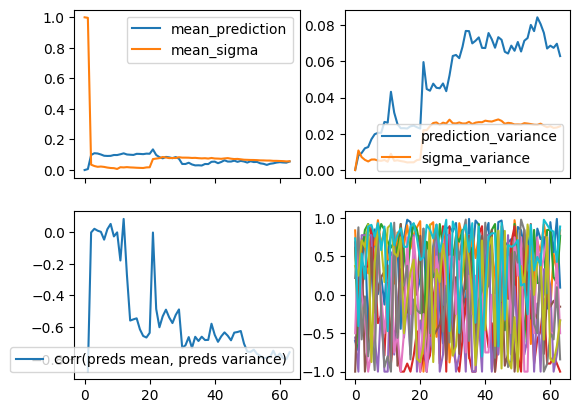

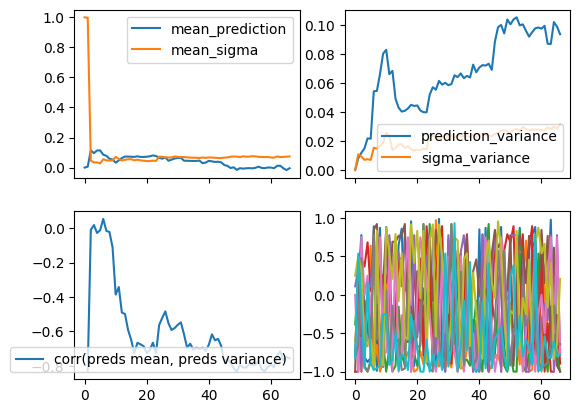

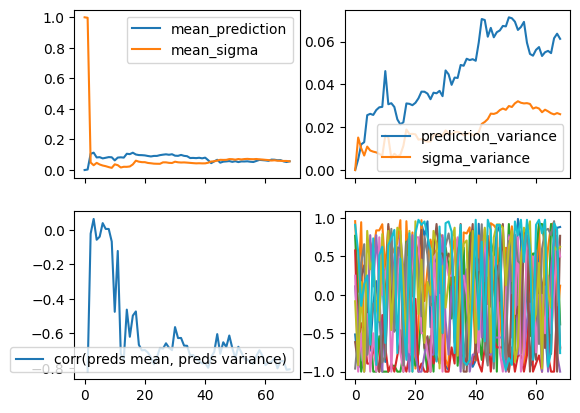

In [22]:
gec.save_figs("./test")

In [24]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'dart', 'num_leaves': 74, 'learning_rate': 0.012931962290146218, 'n_estimators': 80, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 350, 'max_depth': 40, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 33, 'feature_fraction': 0.13}
[LightGBM] [Warning] lambda_l1 is set=0.010833196165895127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010833196165895127
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] l

0.8845874068176551

In [26]:
print(best_params_grid)
knn_bayes = LGBMClassifier(**best_params_grid)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'gbdt', 'num_leaves': 199, 'learning_rate': 0.10645377673723808, 'n_estimators': 10, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 1000, 'max_depth': -1, 'lambda_l1': 1.0, 'min_data_in_leaf': 49, 'feature_fraction': 0.29999999999999993}
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.29999999999999993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29999999999999993
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda

0.885125121252962

In [27]:
gec.export_gp_datas("./gp_datas.json")

In [28]:
np.mean(gec.predict(X))

0.017332447733814087

In [29]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'dart', 'num_leaves': 74, 'learning_rate': 0.012931962290146218, 'n_estimators': 80, 'bagging_fraction': 0.1, 'bagging_freq': 1, 'max_bin': 350, 'max_depth': 40, 'lambda_l1': 0.010833196165895127, 'min_data_in_leaf': 33, 'feature_fraction': 0.13}
[LightGBM] [Warning] lambda_l1 is set=0.010833196165895127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010833196165895127
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] l

0.8845874068176551

In [30]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.categorical_hyperparameters + gec.real_hyperparameters)
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=200)
gs.fit(X_reweighted, y_reweighted)

[LightGBM] [Warning] lambda_l1 is set=0.9744555081102505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744555081102505
[LightGBM] [Warning] bagging_fraction is set=0.9500000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500000000000003
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] feature_fraction is set=0.6499999999999997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6499999999999997
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.9744555081102505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9744555081102505
[LightGBM] [Warning] bagging_fraction is set=0.9500000000000003, subsample=1.0 will be ignored. Cur

In [ ]:
X_eval, y_eval = X_reweighted, y_reweighted
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X_eval, y_eval, cv=5))

knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X_eval, y_eval, cv=5))
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X_eval, y_eval, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=gec.kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gec.gp_datas['gbdt'][0], gec.gp_datas['gbdt'][1])

In [ ]:
visualise_2D_gaussian_process(gaussian, (np.logspace(0.00, 1, 50) -1)/9, np.arange(10, 200, 1), np.arange(0.5, 1, 0.1))

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'gbdt', 'lambda_l1': 0.46, 'num_leaves': 12})
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes